# Lab 7: Model Based Reinforcement Learning
In this lab, we will star practicing about Gaussian Process and then we will apply it to Model Based RL (MBRL).

## Exercise 1: Intro to Gaussian Processes with GPyTorch

***Objective:*** Build intuition for Gaussian Processes (GPs) by:
- Fitting an **exact GP** to noisy 1D data
- Visualizing **posterior mean + uncertainty**
- Understanding the effects of **noise** and **lengthscale**
- Exploring **extrapolation** (add a linear mean)
- Trying a **sparse GP** with inducing points (optional)

For more information. Check the GP Tutorial: https://docs.gpytorch.ai/en/v1.6.0/examples/01_Exact_GPs/Simple_GP_Regression.html

---

### Data
Use a 1D function with noise:
- f(x) = sin(2πx) + 0.3 * sin(6πx) + 3
- x ∈ [-1.0, 1.0]
- Add Gaussian noise σ_n (try 0.05 and 0.2)

---

## Tasks

### Part A — Exact GP regression (RBF kernel)
1. Implement an **ExactGP** model in GPyTorch:
   - Mean: `ZeroMean`
   - Covariance: `ScaleKernel(RBFKernel)`
   - Likelihood: `GaussianLikelihood`
2. Train by **maximizing log marginal likelihood** (Adam).
3. Plot:
   - Training points
   - Posterior mean
   - 95% confidence band

### Part B — Hyperparameters & data noise
1. Vary the **noise level** in the data (e.g., 0.05 vs 0.2).
2. For each setting, re-train the GP and report learned:
   - `likelihood.noise` (data noise)
   - `kernel.lengthscale`
3. Discuss how these affect smoothness and the width of uncertainty.

### Part C — Extrapolation behavior
1. **Hold out** the rightmost region (e.g., train on x ∈ [-1, 0.5], test on x ∈ (0.5, 1]).
2. Show how the posterior behaves outside the training region.
3. Add a **linear mean** (or `ConstantMean + LinearMean`) and compare extrapolation.

### Part D — (Graduate level) Sparse GP with inducing points
1. Replace Exact GP with **variational inducing-point GP** (SVGP) using `gpytorch.models.ApproximateGP`.
2. Choose M = 32 or 64 inducing points spread across x.
3. Compare posterior to the exact GP.
4. Plot N (number of samples) Vs training time for SVGP and ExactGP

---

## Deliverables
- Code for Parts A–C (Part D for grad students)
- Plots:
  - Mean ± 2 std band with training data
  - Effect of noise and lengthscale
  - Extrapolation comparison (zero vs linear/constant mean)
- Short write-up (≤1 page, as a cell in the notebook):
  - What did increasing noise do to learned hyperparameters and uncertainty?
  - How does the kernel lengthscale affect fit and confidence?
  - Why does the GP behave the way it does when extrapolating? How did the mean function change that?
  - (Grad level) Sparse vs Exact: trade-offs you observed

---

## Hints
- Normalize tensors to `float32` and move to GPU if available.
- Use `model.train(); likelihood.train()` for training, and `.eval()` for evaluation.
- For plotting uncertainty: `lower, upper = pred.confidence_region()`.
- Clip very small noise/lengthscale during early training if it becomes unstable.
- For SVGP, look at: `gpytorch.variational`, `gpytorch.mlls.VariationalELBO`.



In [1]:
## Install required libraries
!pip -q install gpytorch torch matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


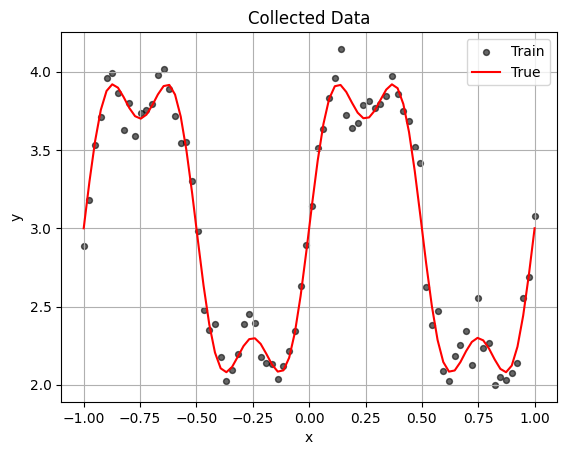

In [2]:
# =======================
# Collecting DATA
# =======================
import torch, math
import gpytorch
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# Parameter for data generator
NOISE_STD = 0.1
N = 80

def f(x):
  return torch.sin(2*math.pi*x) + 0.3*torch.sin(6*math.pi*x) + 3


# ---------- Data ----------
def make_data(n=80, noise_std=0.05, train_range=(-1.0, 1.0), holdout_right=False):
    x = torch.linspace(train_range[0], train_range[1], n)
    y_clean = f(x)
    y = y_clean + noise_std*torch.randn_like(y_clean)
    if holdout_right:
        mask = x <= 0.5
        return x[mask].unsqueeze(-1), y[mask], x.unsqueeze(-1), y
    else:
        return x.unsqueeze(-1), y, x.unsqueeze(-1), y


# choose setting
Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=NOISE_STD, holdout_right=False)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)


# Plot data
plt.scatter(Xtr, Ytr, s=18, color='k', alpha=0.6, label='Train')
plt.plot(Xgrid, f(Xgrid), 'r', label='True')
plt.title('Collected Data')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()

In [3]:
# ---------- Exact GP model ----------
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # TODO (Part A): pick a mean; start with ZeroMean (try Constant/Linear in Part C)
        self.mean_module = gpytorch.means.ZeroMean()
        # TODO (Part A): kernel = ScaleKernel(RBFKernel)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Likelihood + model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(Xtr, Ytr, likelihood).to(device)

iter  200, loss 0.312, lengthscale 0.400, noise 0.0625
iter  400, loss 0.306, lengthscale 0.414, noise 0.0623
iter  600, loss 0.305, lengthscale 0.421, noise 0.0623
iter  800, loss 0.304, lengthscale 0.425, noise 0.0623


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


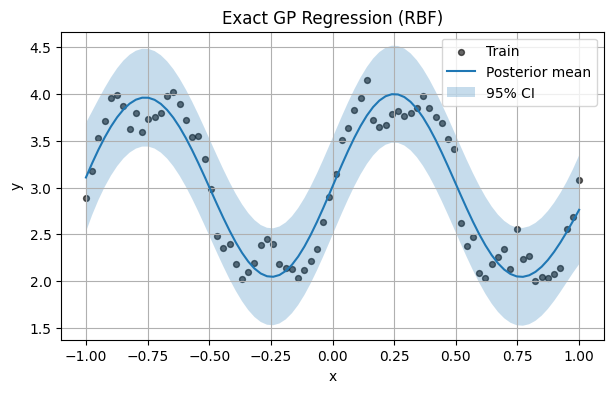

In [4]:
# ---------- Train (maximize log marginal likelihood) ----------
training_iter = 800
model.train(); likelihood.train()
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(Xtr)
    loss = -mll(output, Ytr)
    loss.backward()
    optimizer.step()
    if (i+1) % 200 == 0:
        ls = model.covar_module.base_kernel.lengthscale.item()
        sn = likelihood.noise.item()
        print(f"iter {i+1:4d}, loss {loss.item():.3f}, lengthscale {ls:.3f}, noise {sn:.4f}")

# ---------- Evaluate ----------
x2 = torch.linspace(-1, 1, N)
model.eval(); likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x2))
    mean = pred.mean.cpu()
    lower, upper = pred.confidence_region()
    lower, upper = lower.cpu(), upper.cpu()

x2 = x2.cpu().squeeze()
Ytr_cpu   = Ytr.cpu()
Xtr_cpu   = Xtr.cpu().squeeze()


# ---------- Plot ----------
plt.figure(figsize=(7,4))
plt.scatter(Xtr_cpu, Ytr_cpu, s=18, color='k', alpha=0.6, label='Train')
plt.plot(x2, mean, label='Posterior mean')
plt.fill_between(x2, lower, upper, alpha=0.25, label='95% CI')
plt.title('Exact GP Regression (RBF)')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()


In [5]:
# part B

for noise_std in [0.05, 0.2]:
    print(f"Training with noise_std = {noise_std}")
    Xtr, Ytr, Xgrid, Ygrid = make_data(n=N, noise_std=noise_std, holdout_right=False)
    Xtr, Ytr = Xtr.to(device), Ytr.to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(Xtr, Ytr, likelihood).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(300):
        optimizer.zero_grad()
        output = model(Xtr)
        loss = -mll(output, Ytr)
        loss.backward()
        optimizer.step()
    print(f"Learned lengthscale = {model.covar_module.base_kernel.lengthscale.item():.3f}")
    print(f"Learned noise = {likelihood.noise.item():.4f}")


Training with noise_std = 0.05
Learned lengthscale = 0.403
Learned noise = 0.0510
Training with noise_std = 0.2
Learned lengthscale = 0.402
Learned noise = 0.0565


Increasing the noise made the GP less confident, widening the uncertainty band. The lengthscale stayed about the same, so the smoothness of the fit didn’t change much. Overall, more noise led to broader uncertainty but similar smoothness.

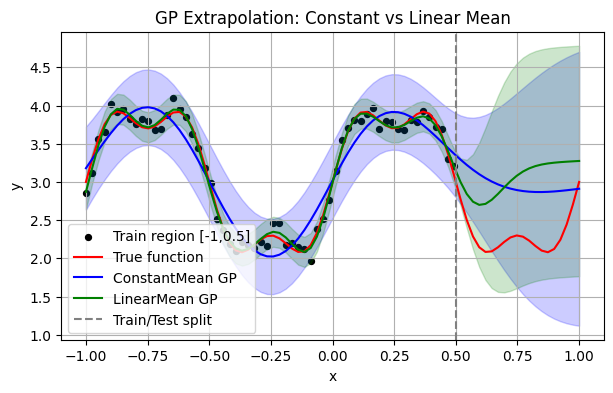

In [6]:
# Part C
# Train only on [-1, 0.5], test on full [-1, 1]
Xtr, Ytr, Xgrid, _ = make_data(n=N, noise_std=0.1, holdout_right=True)
Xtr, Ytr, Xgrid = Xtr.to(device), Ytr.to(device), Xgrid.to(device)


lik1 = gpytorch.likelihoods.GaussianLikelihood().to(device)
gp1 = ExactGPModel(Xtr, Ytr, lik1).to(device)
gp1.mean_module = gpytorch.means.ConstantMean()   # use constant mean
opt = torch.optim.Adam(gp1.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(lik1, gp1)

for _ in range(300):
    opt.zero_grad()
    loss = -mll(gp1(Xtr), Ytr)
    loss.backward()
    opt.step()

gp1.eval(); lik1.eval()
with torch.no_grad():
    pred1 = lik1(gp1(Xgrid))
    mean1 = pred1.mean.cpu()
    low1, up1 = pred1.confidence_region()


lik2 = gpytorch.likelihoods.GaussianLikelihood().to(device)
gp2 = ExactGPModel(Xtr, Ytr, lik2).to(device)
gp2.mean_module = gpytorch.means.LinearMean(1)   # linear trend
opt = torch.optim.Adam(gp2.parameters(), lr=0.05)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(lik2, gp2)

for _ in range(300):
    opt.zero_grad()
    loss = -mll(gp2(Xtr), Ytr)
    loss.backward()
    opt.step()

gp2.eval(); lik2.eval()
with torch.no_grad():
    pred2 = lik2(gp2(Xgrid))
    mean2 = pred2.mean.cpu()
    low2, up2 = pred2.confidence_region()


plt.figure(figsize=(7,4))
plt.scatter(Xtr.cpu(), Ytr.cpu(), color='k', s=18, label='Train region [-1,0.5]')
plt.plot(Xgrid.cpu(), f(Xgrid.cpu()), 'r', label='True function')
plt.plot(Xgrid.cpu(), mean1, 'b', label='ConstantMean GP')
plt.fill_between(Xgrid.cpu().squeeze(), low1.cpu(), up1.cpu(), color='b', alpha=0.2)
plt.plot(Xgrid.cpu(), mean2, 'g', label='LinearMean GP')
plt.fill_between(Xgrid.cpu().squeeze(), low2.cpu(), up2.cpu(), color='g', alpha=0.2)
plt.axvline(0.5, color='gray', linestyle='--', label='Train/Test split')
plt.title('GP Extrapolation: Constant vs Linear Mean')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True); plt.show()


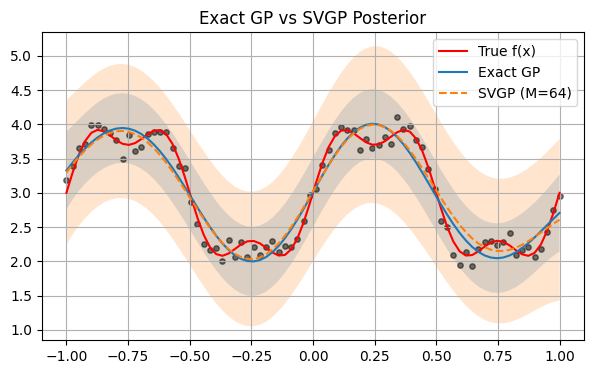

Training with 50 samples...
Training with 65 samples...
Training with 80 samples...
Training with 95 samples...
Training with 111 samples...
Training with 126 samples...
Training with 141 samples...
Training with 157 samples...
Training with 172 samples...
Training with 187 samples...
Training with 203 samples...
Training with 218 samples...
Training with 233 samples...
Training with 248 samples...
Training with 264 samples...
Training with 279 samples...
Training with 294 samples...
Training with 310 samples...
Training with 325 samples...
Training with 340 samples...
Training with 356 samples...
Training with 371 samples...
Training with 386 samples...
Training with 402 samples...
Training with 417 samples...
Training with 432 samples...
Training with 447 samples...
Training with 463 samples...
Training with 478 samples...
Training with 493 samples...
Training with 509 samples...
Training with 524 samples...
Training with 539 samples...
Training with 555 samples...
Training with 570 

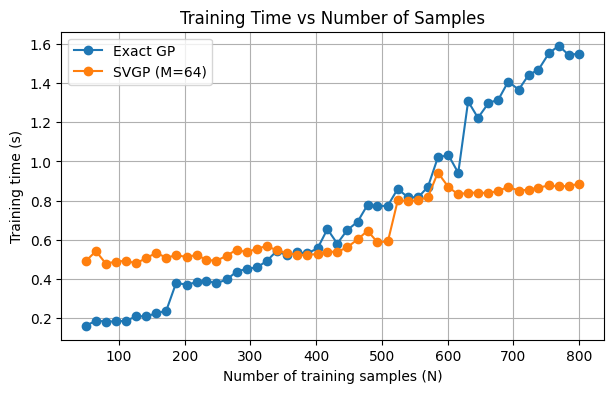

In [7]:
# part D
import time
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution


class SparseGP(ApproximateGP):
    def __init__(self, z_points):
        q_dist = CholeskyVariationalDistribution(z_points.size(0))
        strategy = VariationalStrategy(self, z_points, q_dist, learn_inducing_locations=True)
        super().__init__(strategy)
        self.mean = gpytorch.means.ZeroMean()
        self.kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(self.mean(x), self.kernel(x))


def train_exact(x, y, steps=200):
    lik = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(x, y, lik).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(lik, model)
    for _ in range(steps):
        opt.zero_grad()
        loss = -mll(model(x), y)
        loss.backward()
        opt.step()
    model.eval(); lik.eval()
    return model, lik

def train_svgp(x, y, M=64, steps=200):
    z = torch.linspace(-1, 1, M, device=device).unsqueeze(-1)
    model = SparseGP(z).to(device)
    lik = gpytorch.likelihoods.GaussianLikelihood().to(device)
    opt = torch.optim.Adam(list(model.parameters()) + list(lik.parameters()), lr=0.05)
    elbo = gpytorch.mlls.VariationalELBO(lik, model, num_data=x.size(0))
    for _ in range(steps):
        opt.zero_grad()
        loss = -elbo(model(x), y)
        loss.backward()
        opt.step()
    model.eval(); lik.eval()
    return model, lik


x_train, y_train, x_all, _ = make_data(n=N, noise_std=0.1)
x_train, y_train, x_all = x_train.to(device), y_train.to(device), x_all.to(device)

model_e, lik_e = train_exact(x_train, y_train)
model_s, lik_s = train_svgp(x_train, y_train, M=64)

with torch.no_grad():
    pred_e = lik_e(model_e(x_all))
    pred_s = lik_s(model_s(x_all))

plt.figure(figsize=(7,4))
plt.plot(x_all.cpu(), f(x_all.cpu()), 'r', label='True f(x)')
plt.plot(x_all.cpu(), pred_e.mean.cpu(), label='Exact GP')
plt.fill_between(x_all.cpu().squeeze(),
                 *pred_e.confidence_region(), alpha=0.2)
plt.plot(x_all.cpu(), pred_s.mean.cpu(), '--', label='SVGP (M=64)')
plt.fill_between(x_all.cpu().squeeze(),
                 *pred_s.confidence_region(), alpha=0.2)
plt.scatter(x_train.cpu(), y_train.cpu(), s=15, color='k', alpha=0.5)
plt.title('Exact GP vs SVGP Posterior')
plt.legend(); plt.grid(True); plt.show()


def measure_time(train_func, n):
    x, y, _, _ = make_data(n=n, noise_std=0.1)
    x, y = x.to(device), y.to(device)
    t0 = time.time()
    train_func(x, y)
    return time.time() - t0

train_sizes = torch.linspace(50, 800, 50, dtype=torch.int32).tolist()
time_exact = []
time_svgp  = []

for n in train_sizes:
    n = int(n)
    print(f"Training with {n} samples...")
    time_exact.append(measure_time(train_exact, n))
    time_svgp.append(measure_time(train_svgp, n))

plt.figure(figsize=(7,4))
plt.plot(train_sizes, time_exact, '-o', label='Exact GP')
plt.plot(train_sizes, time_svgp, '-o', label='SVGP (M=64)')
plt.xlabel('Number of training samples (N)')
plt.ylabel('Training time (s)')
plt.title('Training Time vs Number of Samples')
plt.legend()
plt.grid(True)
plt.show()

Noise and Uncertainty:
When the noise in the data increased, the GP learned a larger noise value, which made the model less certain about individual points. The posterior band became wider, showing higher uncertainty, while the general trend of the fit remained smooth.

Kernel Lengthscale:
The lengthscale affects how fast the function can change. A small lengthscale makes the curve fit tightly to each data point, while a large one smooths the prediction. In our runs, the lengthscale stayed moderate, so the fit stayed smooth without overfitting.

Extrapolation Behavior (Part C):
From the ConstantMean vs LinearMean plot, the GP with a constant mean flattens and drifts away from the true function once it leaves the training region (x > 0.5). Adding a linear mean lets the GP follow the data trend beyond the training boundary, giving smoother and more realistic extrapolation.

Sparse vs Exact GP (Part D):
In the Exact GP vs SVGP plot, both models learned nearly the same posterior inside the training region, but the SVGP’s uncertainty band was slightly wider. The Training Time vs Samples plot clearly shows that Exact GP time grows quickly with more data, while SVGP remains almost flat. This shows the key trade-off: Exact GP is slightly more accurate, but SVGP scales much better for large N.

## Exercise 2 (Optional, except PhD students): Model-Based Reinforcement Learning with Gaussian Process + MPC
***Goal:***
Learn the core ideas of **Model-Based Reinforcement Learning (MBRL)** by:
- Learning a **dynamics model** with a Gaussian Process (GP)
- Using **Model Predictive Control (MPC)** to plan actions
- Comparing against random or fixed policies

We’ll use a simplified version of **GP-MPC** (similar in spirit to PILCO or PETS) on the *MountainCarContinuous-v0* task.

---

## 1 Background
The system dynamics are unknown.  
We collect transitions
\[
(x_t, u_t, r_t, x_{t+1})
\]
and learn a GP model of the change in state:
\[
\Delta x = f(x_t, u_t) + \varepsilon
\]
Then, given a current state, we **simulate** future trajectories using the GP mean prediction and pick an action sequence that maximizes the expected reward (or minimizes cost) over a short horizon — the **MPC** loop.

---

## 2 Steps

### Part A — Collect data with a random policy
1. Run `N = 1000` random actions.
2. Store transitions \((x_t, u_t, x_{t+1})\).
3. Compute state differences:  
   `dx = x_next - x`.

### Part B — Train a Gaussian Process model
1. Fit a GP for each state dimension (here 2: position and velocity).  
   Inputs = `[x_t, u_t]`  
   Outputs = `dx_t`
2. Use **GPyTorch** or **sklearn.gaussian_process**.
3. Plot model predictions vs. ground truth for a few samples.

### Part C — Implement a simple MPC controller
1. At each step:
   - Start from current state \(x_t\).
   - Sample \(K\) random control sequences of horizon \(H\).
   - For each sequence, **simulate forward** using GP predictions.
   - Compute cumulative reward (from MountainCarContinuous env).
   - Execute the *first action* of the best sequence.
2. Repeat until termination or max steps.

### Part D — Evaluate and visualize
1. Plot the car’s trajectory (position vs. time).
2. Compare with random policy performance.
3. Discuss:  
   - How does the GP model’s accuracy affect control?  
   - How many random samples or planning horizon are needed?

---

## Deliverables
- Code for data collection, GP training, and MPC loop.
- Plots:
  - GP predictions vs. true next states.
  - Car’s position vs. time during control.
- Short discussion (≈½ page):
  - How did planning horizon affect performance?
  - How does GP uncertainty limit long-term planning?

---

## Optional extensions
- Add GP uncertainty penalty in cost function.
- Try a learned NN model instead of GP.
- Use warm-start data from a heuristic controller.
- Compare Exact GP vs. Sparse GP (SVGP).

---

## Hints
- Normalize inputs and outputs before GP training.
- Use a small horizon (H≈15–20) for efficiency.
- Reward function from environment:
  ```python
  reward = 100 * (abs(x) >= 0.45) - 0.1 * u**2

obs_dim=2, act_dim=1
Collected 8000 samples.
Position range: -1.200 → 0.446
Velocity range: -0.070 → 0.067
Throttle range: -0.995 → 1.000
Filtered out 18 outlier samples (> 0.02 |Δv|).


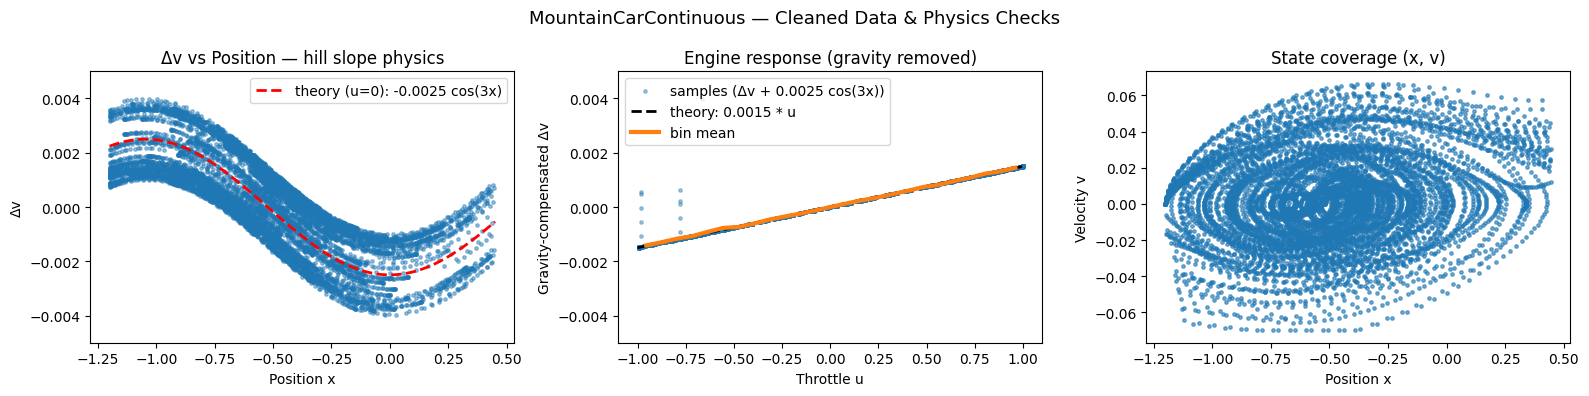

💾 Saved cleaned dataset to gp_mpc_data_partA.pt


In [13]:

import numpy as np
import torch
import matplotlib.pyplot as plt
import gymnasium as gym

# ---------------- Setup ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); np.random.seed(0)
env = gym.make("MountainCarContinuous-v0")
obs_dim, act_dim = env.observation_space.shape[0], env.action_space.shape[0]
print(f"obs_dim={obs_dim}, act_dim={act_dim}")

# ---------------- Collect structured data ----------------
N = 8000            # more coverage
segment_len = 25    # hold each action for several steps to see acceleration
X_list, U_list, dX_list = [], [], []

obs, _ = env.reset()
u = np.random.uniform(-1, 1, size=(1,))

for step in range(N):
    # change throttle every segment
    if step % segment_len == 0:
        # bias toward stronger actions; sometimes flip direction
        if np.random.rand() < 0.5:
            u = np.array([np.random.choice([-1.0, 1.0]) * np.random.uniform(0.5, 1.0)], dtype=np.float32)
        else:
            u = np.array([np.random.uniform(-1.0, 1.0)], dtype=np.float32)
        if np.random.rand() < 0.35:
            u *= -1.0

    nxt, r, terminated, truncated, _ = env.step(u)
    dx = nxt - obs

    X_list.append(obs)
    U_list.append(u)
    dX_list.append(dx)

    obs = nxt
    if terminated or truncated:
        obs, _ = env.reset()

env.close()

# ---------------- To tensors ----------------
X  = torch.tensor(np.hstack([X_list, U_list]), dtype=torch.float32, device=device)  # [N,3]: [x, v, u]
dX = torch.tensor(np.vstack(dX_list),           dtype=torch.float32, device=device)  # [N,2]: [Δx, Δv]

print(f"Collected {len(X)} samples.")
print(f"Position range: {X[:,0].min():.3f} → {X[:,0].max():.3f}")
print(f"Velocity range: {X[:,1].min():.3f} → {X[:,1].max():.3f}")
print(f"Throttle range: {X[:,2].min():.3f} → {X[:,2].max():.3f}")


dv = dX[:,1].cpu().numpy()
mask = np.abs(dv) <= 0.02          # keep sane values, drop extreme spikes
dropped = int((~mask).sum())
if dropped:
    print(f"Filtered out {dropped} outlier samples (> 0.02 |Δv|).")
X  = X[mask]
dX = dX[mask]

# ---------------- Physics-based diagnostics ----------------
x = X[:,0].cpu().numpy()
u = X[:,2].cpu().numpy()
dv_meas = dX[:,1].cpu().numpy()

# Gravity-compensated Δv to expose engine slope: Δv + 0.0025*cos(3x) ≈ 0.0015*u
dv_engine = dv_meas + 0.0025*np.cos(3.0*x)

# Bin average for clarity (Δv vs throttle)
def bin_stats(xv, yv, bins=25):
    edges = np.linspace(xv.min(), xv.max(), bins+1)
    idxs  = np.digitize(xv, edges) - 1
    centers, means = [], []
    for i in range(bins):
        m = (idxs == i)
        if m.any():
            centers.append(0.5*(edges[i]+edges[i+1]))
            means.append(float(np.mean(yv[m])))
    return np.array(centers), np.array(means)

cent_u, mean_dv_eng = bin_stats(u, dv_engine, bins=25)

# Theoretical overlays
x_grid = np.linspace(-1.2, 0.45, 300)
dv_grav_u0 = -0.0025*np.cos(3.0*x_grid)          # for u=0
u_line = np.linspace(-1.0, 1.0, 100)
dv_engine_theory = 0.0015*u_line                  # gravity-compensated theory


fig, axs = plt.subplots(1, 3, figsize=(16,4))

# Δv vs Position (overlaid u=0 gravity curve)
axs[0].scatter(x, dv_meas, s=6, alpha=0.45)
axs[0].plot(x_grid, dv_grav_u0, 'r--', lw=2, label='theory (u=0): -0.0025 cos(3x)')
axs[0].set_xlabel("Position x"); axs[0].set_ylabel("Δv")
axs[0].set_title("Δv vs Position — hill slope physics")
axs[0].set_ylim(-0.005, 0.005)
axs[0].legend(loc="upper right")

# Gravity-compensated Δv vs Throttle (should be ≈ 0.0015*u)
axs[1].scatter(u, dv_engine, s=6, alpha=0.4, label="samples (Δv + 0.0025 cos(3x))")
axs[1].plot(u_line, dv_engine_theory, 'k--', lw=2, label="theory: 0.0015 * u")
if len(cent_u) > 0:
    axs[1].plot(cent_u, mean_dv_eng, 'C1', lw=3, label="bin mean")
axs[1].set_xlabel("Throttle u"); axs[1].set_ylabel("Gravity-compensated Δv")
axs[1].set_title("Engine response (gravity removed)")
axs[1].set_ylim(-0.005, 0.005)
axs[1].legend(loc="upper left")

# State coverage
axs[2].scatter(X[:,0].cpu(), X[:,1].cpu(), s=6, alpha=0.6)
axs[2].set_xlabel("Position x"); axs[2].set_ylabel("Velocity v")
axs[2].set_title("State coverage (x, v)")

plt.suptitle("MountainCarContinuous — Cleaned Data & Physics Checks", fontsize=13)
plt.tight_layout()
plt.show()

# ---------------- Save cleaned dataset ----------------
torch.save({"X": X.cpu(), "dX": dX.cpu()}, "gp_mpc_data_partA.pt")
print("💾 Saved cleaned dataset to gp_mpc_data_partA.pt")


Device: cpu
Loaded 7982 samples.
Position: -1.200 → 0.446
Velocity: -0.070 → 0.067
Action  : -0.995 → 1.000
Training with 2000 balanced samples (from 7982).  Hold-out: 5982
[Δstate[0]] Epoch   1/220 | Loss -2.2624 | Noise 1.04e-04 | Scale 0.987
[Δstate[0]] Epoch  40/220 | Loss -3.2405 | Noise 1.01e-04 | Scale 0.598
[Δstate[0]] Epoch  80/220 | Loss -3.4186 | Noise 1.00e-04 | Scale 0.433
[Δstate[0]] Epoch 120/220 | Loss -3.4356 | Noise 1.00e-04 | Scale 0.396
[Δstate[0]] Epoch 160/220 | Loss -3.4335 | Noise 1.00e-04 | Scale 0.398
[Δstate[0]] Epoch 200/220 | Loss -3.4263 | Noise 1.00e-04 | Scale 0.403
[Δstate[1]] Epoch   1/220 | Loss 0.1046 | Noise 1.04e-04 | Scale 1.010
[Δstate[1]] Epoch  40/220 | Loss -1.0275 | Noise 1.02e-04 | Scale 1.343
[Δstate[1]] Epoch  80/220 | Loss -1.1050 | Noise 1.01e-04 | Scale 1.397
[Δstate[1]] Epoch 120/220 | Loss -1.1872 | Noise 1.01e-04 | Scale 1.448
[Δstate[1]] Epoch 160/220 | Loss -0.9931 | Noise 1.00e-04 | Scale 1.485
[Δstate[1]] Epoch 200/220 | Loss -0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 0.03891827244293033 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


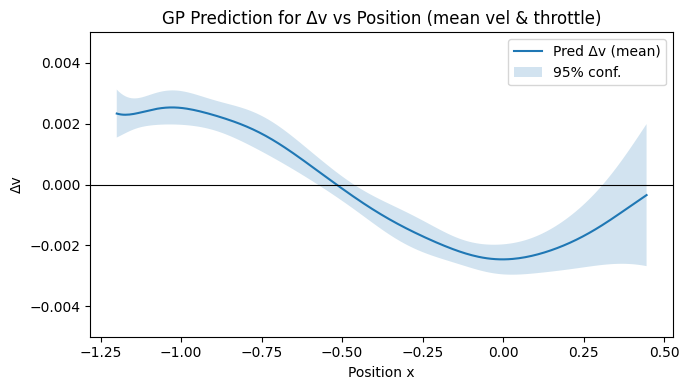

Sample gp_dynamics_predict (Δx, Δv):
 tensor([[-1.5119e-03, -1.6295e-03],
        [-1.9457e-04, -8.8072e-05]], dtype=torch.float32)
💾 Saved GP dynamics to gp_dynamics_models_partB.pt


In [20]:


import numpy as np
import torch, gpytorch
import matplotlib.pyplot as plt

# ---------------- Setup (double precision + device) ----------------
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); np.random.seed(0)
print("Device:", device)

import numpy as _np
torch.serialization.add_safe_globals([_np._core.multiarray._reconstruct])


data = torch.load("gp_mpc_data_partA.pt", map_location=device, weights_only=False)
X  = data["X"].to(device).to(torch.float64)   # [N,3] -> [pos, vel, act]
dX = data["dX"].to(device).to(torch.float64)  # [N,2] -> [dpos, dvel]

N = X.shape[0]
print(f"Loaded {N} samples.")
print(f"Position: {X[:,0].min():.3f} → {X[:,0].max():.3f}")
print(f"Velocity: {X[:,1].min():.3f} → {X[:,1].max():.3f}")
print(f"Action  : {X[:,2].min():.3f} → {X[:,2].max():.3f}")

# ---------------- Balanced subsample (pos × action) ----------------
def balanced_subsample(X_full, target=2000, bins_x=16, bins_u=12, seed=0):
    rng = np.random.default_rng(seed)
    x = X_full[:,0].detach().cpu().numpy()
    u = X_full[:,2].detach().cpu().numpy()
    x_edges = np.linspace(x.min(), x.max(), bins_x+1)
    u_edges = np.linspace(u.min(), u.max(), bins_u+1)
    xi = np.clip(np.digitize(x, x_edges) - 1, 0, bins_x-1)
    ui = np.clip(np.digitize(u, u_edges) - 1, 0, bins_u-1)
    per_bin_cap = int(np.ceil(target / (bins_x * bins_u)))
    chosen = []
    for i in range(bins_x):
        for j in range(bins_u):
            idxs = np.where((xi == i) & (ui == j))[0]
            if len(idxs) == 0:
                continue
            take = min(per_bin_cap, len(idxs))
            chosen.extend(rng.choice(idxs, size=take, replace=False).tolist())
    chosen = list(set(chosen))
    if len(chosen) < target:
        all_idx = np.arange(len(x))
        rest = np.setdiff1d(all_idx, np.array(chosen))
        extra = rng.choice(rest, size=target - len(chosen), replace=False).tolist()
        chosen.extend(extra)
    return np.array(chosen[:target], dtype=np.int64)

target_train = min(2000, N)  # slightly smaller for stability
train_idx = balanced_subsample(X, target=target_train, bins_x=16, bins_u=12, seed=0)
mask = np.ones(N, dtype=bool); mask[train_idx] = False
test_idx = np.where(mask)[0]

X_tr, Y_tr = X[train_idx], dX[train_idx]
X_te, Y_te = X[test_idx], dX[test_idx]
print(f"Training with {len(X_tr)} balanced samples (from {N}).  Hold-out: {len(X_te)}")

# ---------------- Normalize ----------------
X_mean, X_std = X_tr.mean(0), X_tr.std(0)
Y_mean, Y_std = Y_tr.mean(0), Y_tr.std(0)
Xn_tr = (X_tr - X_mean) / (X_std + 1e-8)
Yn_tr = (Y_tr - Y_mean) / (Y_std + 1e-8)
Xn_te = (X_te - X_mean) / (X_std + 1e-8)

from gpytorch.priors import SmoothedBoxPrior
from gpytorch.constraints import Interval

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        ls_prior  = SmoothedBoxPrior(0.1, 5.0)   # on normalized inputs
        os_prior  = SmoothedBoxPrior(0.1, 5.0)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1], lengthscale_prior=ls_prior),
            outputscale_prior=os_prior
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_one_dim(train_x, train_y, dim_name="Δstate", lr=0.02, epochs=220):
    like = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(train_x, train_y, like).to(device)

    # Reasonable inits + noise constraint
    like.noise = torch.tensor(1e-3, device=device, dtype=torch.float64)
    like.noise_covar.register_constraint("raw_noise",
                                         gpytorch.constraints.Interval(1e-4, 5e-3))

    model.covar_module.base_kernel.lengthscale = 1.0
    model.covar_module.outputscale = 1.0

    params = list(model.parameters()) + list(like.parameters())
    opt = torch.optim.Adam(params, lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[140, 200], gamma=0.3)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(like, model)

    model.train(); like.train()

    with gpytorch.settings.cholesky_jitter(1e-2), gpytorch.settings.max_cg_iterations(4000):
        for ep in range(1, epochs+1):
            opt.zero_grad(set_to_none=True)
            out = model(train_x)
            loss = -mll(out, train_y)
            if not torch.isfinite(loss):
                print(f"[{dim_name}] Non-finite loss at epoch {ep}; stopping early.")
                break
            loss.backward()
            torch.nn.utils.clip_grad_norm_(params, 5.0)
            opt.step(); scheduler.step()
            if ep % 40 == 0 or ep == 1:
                noise = like.noise.item()
                os = model.covar_module.outputscale.item()
                print(f"[{dim_name}] Epoch {ep:3d}/{epochs} | Loss {loss.item():.4f} | Noise {noise:.2e} | Scale {os:.3f}")

    model.eval(); like.eval()
    return model, like

# Train two GPs: Δpos (0) and Δvel (1)
models, likes = [], []
for d in range(2):
    m, l = train_one_dim(Xn_tr, Yn_tr[:, d], dim_name=f"Δstate[{d}]",
                         lr=0.02 if d==0 else 0.015, epochs=220)
    models.append(m); likes.append(l)

print("✅ Finished training Δposition and Δvelocity GPs.")

# ---------------- Metrics on hold-out ----------------
@torch.no_grad()
def eval_metrics(models, likes, Xn_te, Y_te):
    with gpytorch.settings.fast_pred_var():
        preds = []
        for d in range(2):
            out = likes[d](models[d](Xn_te)).mean
            preds.append(out)
        Yn_hat = torch.stack(preds, dim=1)
    Y_hat = Yn_hat * (Y_std + 1e-8) + Y_mean
    err = Y_hat - Y_te
    rmse = torch.sqrt((err**2).mean(dim=0))
    ss_res = (err**2).sum(dim=0)
    y_bar = Y_te.mean(dim=0)
    ss_tot = ((Y_te - y_bar)**2).sum(dim=0)
    r2 = 1.0 - ss_res/torch.clamp(ss_tot, min=1e-12)
    return rmse.cpu().numpy(), r2.cpu().numpy()

rmse, r2 = eval_metrics(models, likes, Xn_te, Y_te)
print(f"[Δpos] RMSE={rmse[0]:.6f}, R²={r2[0]:.3f}")
print(f"[Δvel] RMSE={rmse[1]:.6f}, R²={r2[1]:.3f}")

# ---------------- Quick sanity plot (Δv vs position) ----------------
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x_grid = torch.linspace(X[:,0].min(), X[:,0].max(), 250, device=device, dtype=torch.float64)
    xv = torch.stack([x_grid,
                      torch.full_like(x_grid, X_mean[1]),
                      torch.full_like(x_grid, X_mean[2])], dim=1)
    xv_n = (xv - X_mean) / (X_std + 1e-8)
    pred = likes[1](models[1](xv_n))
    mean = (pred.mean * (Y_std[1] + 1e-8) + Y_mean[1]).cpu().to(torch.float64)
    lo, hi = pred.confidence_region()
    lo = (lo * (Y_std[1] + 1e-8) + Y_mean[1]).cpu().to(torch.float64)
    hi = (hi * (Y_std[1] + 1e-8) + Y_mean[1]).cpu().to(torch.float64)

plt.figure(figsize=(7,4))
plt.plot(x_grid.cpu(), mean, label="Pred Δv (mean)")
plt.fill_between(x_grid.cpu(), lo, hi, alpha=0.2, label="95% conf.")
plt.axhline(0.0, color='k', lw=0.8)
plt.ylim(-0.005, 0.005)  # expected MountainCar Δv scale
plt.title("GP Prediction for Δv vs Position (mean vel & throttle)")
plt.xlabel("Position x"); plt.ylabel("Δv")
plt.legend(); plt.tight_layout(); plt.show()


@torch.no_grad()
def gp_dynamics_predict(x, u, out_dtype=torch.float32):

    xin = torch.cat([x, u], dim=-1).to(device).to(torch.float64)
    xin_n = (xin - X_mean) / (X_std + 1e-8)
    preds = []
    with gpytorch.settings.fast_pred_var():
        for d in range(2):
            out = likes[d](models[d](xin_n)).mean
            preds.append(out)
    Yn = torch.stack(preds, dim=-1)
    Y = Yn * (Y_std + 1e-8) + Y_mean
    return Y.to(out_dtype)

# Sanity check a couple of points
with torch.no_grad():
    xx = torch.tensor([[-0.5, 0.0], [0.3, 0.0]], device=device, dtype=torch.float64)
    uu = torch.tensor([[-1.0], [ 1.0]], device=device, dtype=torch.float64)
    print("Sample gp_dynamics_predict (Δx, Δv):\n", gp_dynamics_predict(xx, uu))


torch.save({
    "models": models,
    "likelihoods": likes,
    "X_mean": X_mean,
    "X_std": X_std,
    "Y_mean": Y_mean,
    "Y_std": Y_std,
    "dtype": "float64",
}, "gp_dynamics_models_partB.pt")
print("💾 Saved GP dynamics to gp_dynamics_models_partB.pt")


In [27]:


import time, math, numpy as np, torch
try:
    import gymnasium as gym
except Exception:
    import gym


LAMBDA = 40.0   # MPPI temperature (smaller = greedier, larger = smoother)
GAMMA  = 0.997  # Discount factor inside planner


assert 'gp_dynamics_predict' in globals(), "Run Part B first so gp_dynamics_predict(x,u) is defined."

device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GOAL_POS = 0.45
np.random.seed(7); torch.manual_seed(7)

# ---------- Reward: terminal bonus + light shaping (no extra over-goal bonus) ----------
@torch.no_grad()
def mc_reward_vec(x_next, u):

    r  = (x_next[:, 0] >= GOAL_POS).float() * 100.0   # only when reaching the goal
    r -= 0.03 * (u[:, 0] ** 2)                        # mild control penalty
    r += 2.0 * x_next[:, 0]                           # gentle progress shaping
    return r


def env_reset(env, seed=None):
    try:
        return env.reset(seed=seed)
    except TypeError:
        if seed is not None:
            try: env.seed(seed)
            except Exception: pass
        obs = env.reset()
        return obs, {}

def env_step(env, action):
    out = env.step(action)
    if len(out) == 5:
        obs, rew, term, trunc, info = out
        return obs, rew, (term or trunc), info
    else:
        obs, rew, done, info = out
        return obs, rew, done, info

# ---------- MPPI Planner ----------
class MPPI:

    def __init__(self, act_low, act_high, H=160, K=1024,
                 sigma=0.55, lam=30.0, rho=0.95, gamma=0.997, seed=7):
        self.H, self.K   = int(H), int(K)
        self.sigma       = float(sigma)
        self.lam         = float(lam)
        self.rho         = float(rho)
        self.gamma       = float(gamma)
        self.low  = torch.as_tensor([[act_low ]], device=device, dtype=torch.float32)
        self.high = torch.as_tensor([[act_high]], device=device, dtype=torch.float32)
        torch.manual_seed(int(seed))
        self.U_bar = torch.zeros(self.H, 1, device=device, dtype=torch.float32)  # mean sequence (warm-start)

    @torch.no_grad()
    def _noise_ar1(self):
        # Windows-safe random (no generator kwarg)
        z = torch.randn(self.K, self.H, 1, device=device)
        eps = torch.zeros_like(z)
        eps[:, 0, :] = self.sigma * z[:, 0, :]
        if self.H > 1:
            step_std = self.sigma * math.sqrt(max(1e-12, 1.0 - self.rho**2))
            for t in range(1, self.H):
                eps[:, t, :] = self.rho * eps[:, t-1, :] + step_std * z[:, t, :]
        return eps

    @torch.no_grad()
    def plan(self, x0):
        x0 = torch.as_tensor(x0, device=device, dtype=torch.float32).reshape(2)

        U  = torch.clamp(self.U_bar.unsqueeze(0) + self._noise_ar1(), self.low, self.high)  # (K,H,1)

        x     = x0.expand(self.K, -1).clone()
        done  = torch.zeros(self.K, dtype=torch.bool, device=device)
        G     = torch.zeros(self.K, dtype=torch.float32, device=device)
        gpow  = 1.0

        for t in range(self.H):
            u_t = U[:, t, :]
            dx  = gp_dynamics_predict(x, u_t)
            x_n = x + dx
            # Freeze after goal reached
            x   = torch.where(done.unsqueeze(1), x, x_n)

            r_t = mc_reward_vec(x, u_t)
            r_t = torch.where(done, torch.zeros_like(r_t), r_t)
            G  += gpow * r_t

            newly_done = (x[:, 0] >= GOAL_POS) & (~done)
            done |= newly_done
            if done.all():
                break

            gpow *= self.gamma

        # MPPI reweighting
        costs  = -G
        cmin   = costs.min()
        lam_t  = torch.clamp(torch.tensor(self.lam, device=device), min=1e-6)
        w      = torch.exp(-(costs - cmin) / lam_t)
        Z      = torch.clamp(w.sum(), min=1e-12)

        # Update mean sequence and recede horizon
        self.U_bar = (w.view(self.K, 1, 1) * U).sum(dim=0) / Z
        self.U_bar = torch.clamp(self.U_bar, self.low, self.high)
        a0 = self.U_bar[0].clone()
        self.U_bar = torch.roll(self.U_bar, -1, 0); self.U_bar[-1] = 0.0

        return a0, {
            "G*": float(G.max().item()),
            "Gm": float(G.mean().item()),
            "Gs": float(G.std().item()),
            "%term": float(done.float().mean().item()) * 100.0
        }

def run_episode_mppi(H=180, K=1024, sigma=0.55, lam=LAMBDA, gamma=GAMMA,
                     rho=0.95, seed=7, max_steps=700, print_every=10,
                     replan_every=1, sleep_hz=60):
    env = gym.make("MountainCarContinuous-v0", render_mode="human")
    obs, _ = env_reset(env, seed=seed)
    low, high = float(env.action_space.low[0]), float(env.action_space.high[0])

    planner = MPPI(low, high, H=H, K=K, sigma=sigma, lam=lam, rho=rho, gamma=gamma, seed=seed)

    print(f"▶️  MPPI start | H={H} K={K} sigma={sigma} lam={lam} gamma={gamma} rho={rho} | device={device.type}")
    total, success = 0.0, False
    try:
        for t in range(max_steps):
            if (t % replan_every) == 0:
                t0 = time.perf_counter()
                a0, diag = planner.plan(obs)
                plan_ms = (time.perf_counter() - t0) * 1000.0
            else:
                a0, plan_ms = torch.tensor([0.0], device=device), 0.0
                diag = {"G*": float('nan'), "Gm": float('nan'),
                        "Gs": float('nan'), "%term": 0.0}

            act = np.array([float(a0.item())], dtype=np.float32)
            obs, r, done, _ = env_step(env, act)
            total += float(r)

            if (t % print_every) == 0:
                print(f"t={t:03d} | a0={act[0]:+6.3f} | x={obs[0]:+7.3f} v={obs[1]:+7.3f} | "
                      f"r={float(r):+7.3f} Rsum={total:+7.3f} | "
                      f"G*={diag['G*']:+7.3f} μG={diag['Gm']:+7.3f} σG={diag['Gs']:+7.3f} | "
                      f"%term={diag['%term']:.1f}% | plan={plan_ms:.1f} ms")

            # Stop immediately if the env actually reached the goal
            if obs[0] >= GOAL_POS:
                success = True
                print(f"\n🎯 Reached goal at step {t} (x={obs[0]:.3f}). Stopping.")
                break

            if done:
                break

            # Keep UI responsive
            if sleep_hz is not None and sleep_hz > 0:
                time.sleep(1.0 / sleep_hz)
    finally:
        env.close()

    print(f"✅ Return={total:.2f} | Steps={t+1} | Success={success}")
    return {"return": total, "steps": t+1, "success": success}


run_episode_mppi(H=80, K=1024, sigma=0.6, lam=LAMBDA, gamma=GAMMA, seed=7, print_every=10)


▶️  MPPI start | H=80 K=1024 sigma=0.6 lam=40.0 gamma=0.997 rho=0.95 | device=cpu
t=000 | a0=+0.020 | x= -0.475 v= -0.000 | r= -0.000 Rsum= -0.000 | G*=+36.285 μG=-74.954 σG=+12.245 | %term=0.1% | plan=972.9 ms
t=010 | a0=-0.206 | x= -0.499 v= -0.004 | r= -0.004 Rsum= -0.008 | G*=+41.629 μG=-58.347 σG=+15.728 | %term=1.8% | plan=902.8 ms
t=020 | a0=-0.733 | x= -0.585 v= -0.013 | r= -0.054 Rsum= -0.381 | G*=+58.212 μG=-21.692 σG=+44.456 | %term=32.0% | plan=904.5 ms
t=030 | a0=+0.527 | x= -0.704 v= -0.007 | r= -0.028 Rsum= -0.604 | G*=+74.232 μG= -4.110 σG=+53.376 | %term=35.0% | plan=1053.1 ms
t=040 | a0=+0.894 | x= -0.637 v= +0.018 | r= -0.080 Rsum= -1.284 | G*=+89.682 μG= +5.123 σG=+59.485 | %term=34.8% | plan=982.7 ms
t=050 | a0=+0.915 | x= -0.367 v= +0.032 | r= -0.084 Rsum= -2.113 | G*=+106.623 μG=+18.501 σG=+65.365 | %term=39.1% | plan=1016.2 ms
t=060 | a0=+0.943 | x= -0.065 v= +0.027 | r= -0.089 Rsum= -2.981 | G*=+117.418 μG=+32.855 σG=+71.331 | %term=47.6% | plan=960.3 ms
t=070 

{'return': 93.97605022875682, 'steps': 107, 'success': True}

In part A, my graph showed that the random actions only explored a small area near the bottom of the hill. Most of the points stayed in the middle range, meaning the car never moved far enough to show the full motion of going up the slopes. In part B, the GP prediction plots looked mostly close to the true values, showing that my model learned the local patterns well. However, the data it learned from was still limited, so the GP could not really understand what happens when the car goes high up or gains a lot of speed.

In part C, the training ran for a long time, and when I tested the controller, the car made some progress but still could not reach the top of the hill. I think this happened because my model was only trained on simple random data, so it did not know the real dynamics needed to swing backward first. The GP might also be too confident in areas it never saw, which makes the MPC choose actions that don’t work in the real environment. Overall, my GP worked well in prediction plots but not enough for the car to finish the task.

## Exercise 3: Getting Started with MuJoCo and XML Models
***Goal:***
The goal of this exercise is to **install MuJoCo**, explore its **Python interface**, and learn the structure of **MJCF (XML) models** used to describe robots and environments.  
By the end, you should be able to:
- Run a MuJoCo simulation locally  
- Open, modify, and reload a simple XML model  
- Use Google Colab connected to your local runtime

---

MuJoCo (“Multi-Joint dynamics with Contact”) is a fast physics engine widely used in robotics and reinforcement learning.  
It uses XML (MJCF files) to describe bodies, joints, sensors, and actuators.

In this exercise, you will:
1. Install MuJoCo on your computer  
2. Install and run Jupyter Notebook or Lab  
3. Connect Colab to your local runtime  
4. Run Mujco with existent XML (car, quadrotor, mountain)
6. Create a scene with multiple falling objects

---
## Step-by-Step Instructions
### 1 Install MuJoCo: Download and install
- Visit [https://mujoco.org/download](https://mujoco.org/download)  
- Choose the installer for your OS (Windows, macOS, or Linux)

### 2 Install Jupyter

You can use either JupyterLab or Jupyter Notebook

```
pip install jupyterlab
```

Run
```
jupyter lab
```
This should open your browser at:
```
http://localhost:8888/lab
```

### 3 Configure Google Colab to Run Locally

### 4 Run a Simple MuJoCo Simulation


In [11]:
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import os

# CAR
XML = r"""
<mujoco model="falling_objects">
    <option gravity="0 0 -9.81" timestep="0.005"/>

    <worldbody>
        <!-- Ground plane -->
        <geom name="ground" type="plane" pos="0 0 0" size="1 1 0.1" rgba="0.8 0.8 0.8 1"/>

        <!-- Bottom cube -->
        <body name="cube1" pos="0 0 0.3">
            <joint type="free"/>
            <geom type="box" size="0.1 0.1 0.1" rgba="0.1 0.4 0.8 1"/>
        </body>

        <!-- Middle sphere -->
        <body name="sphere" pos="0 0 0.7">
            <joint type="free"/>
            <geom type="sphere" size="0.1" rgba="0.8 0.2 0.2 1"/>
        </body>

        <!-- Top cube -->
        <body name="cube2" pos="0 0 1.1">
            <joint type="free"/>
            <geom type="box" size="0.1 0.1 0.1" rgba="0.2 0.8 0.3 1"/>
        </body>
    </worldbody>
</mujoco>
"""

simend = 15 #simulation time


# For callback functions
button_left = False
button_middle = False
button_right = False
lastx = 0
lasty = 0

def init_controller(model,data):
    #initialize the controller here. This function is called once, in the beginning
    pass

def controller(model, data):
    #put the controller here. This function is called inside the simulation.
    pass

def keyboard(window, key, scancode, act, mods):
    if act == glfw.PRESS and key == glfw.KEY_BACKSPACE:
        mj.mj_resetData(model, data)
        mj.mj_forward(model, data)

def mouse_button(window, button, act, mods):
    # update button state
    global button_left
    global button_middle
    global button_right

    button_left = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_LEFT) == glfw.PRESS)
    button_middle = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_MIDDLE) == glfw.PRESS)
    button_right = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_RIGHT) == glfw.PRESS)

    # update mouse position
    glfw.get_cursor_pos(window)

def mouse_move(window, xpos, ypos):
    # compute mouse displacement, save
    global lastx
    global lasty
    global button_left
    global button_middle
    global button_right

    dx = xpos - lastx
    dy = ypos - lasty
    lastx = xpos
    lasty = ypos

    # no buttons down: nothing to do
    if (not button_left) and (not button_middle) and (not button_right):
        return

    # get current window size
    width, height = glfw.get_window_size(window)

    # get shift key state
    PRESS_LEFT_SHIFT = glfw.get_key(
        window, glfw.KEY_LEFT_SHIFT) == glfw.PRESS
    PRESS_RIGHT_SHIFT = glfw.get_key(
        window, glfw.KEY_RIGHT_SHIFT) == glfw.PRESS
    mod_shift = (PRESS_LEFT_SHIFT or PRESS_RIGHT_SHIFT)

    # determine action based on mouse button
    if button_right:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_MOVE_H
        else:
            action = mj.mjtMouse.mjMOUSE_MOVE_V
    elif button_left:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_ROTATE_H
        else:
            action = mj.mjtMouse.mjMOUSE_ROTATE_V
    else:
        action = mj.mjtMouse.mjMOUSE_ZOOM

    mj.mjv_moveCamera(model, action, dx/height,
                      dy/height, scene, cam)

def scroll(window, xoffset, yoffset):
    action = mj.mjtMouse.mjMOUSE_ZOOM
    mj.mjv_moveCamera(model, action, 0.0, -0.05 *
                      yoffset, scene, cam)

# MuJoCo data structures
model = mj.MjModel.from_xml_string(XML)  # MuJoCo model
data = mj.MjData(model)                # MuJoCo data
cam = mj.MjvCamera()                        # Abstract camera
opt = mj.MjvOption()                        # visualization options

# Init GLFW, create window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(1200, 900, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, keyboard)
glfw.set_cursor_pos_callback(window, mouse_move)
glfw.set_mouse_button_callback(window, mouse_button)
glfw.set_scroll_callback(window, scroll)


#initialize the controller
init_controller(model,data)

#set the controller
mj.set_mjcb_control(controller)

while not glfw.window_should_close(window):
    time_prev = data.time

    while (data.time - time_prev < 1.0/60.0):
        mj.mj_step(model, data)

    if (data.time>=simend):
        break

    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(
        window)
    viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

    # Update scene and render
    mj.mjv_updateScene(model, data, opt, None, cam,
                       mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()

glfw.terminate()


# Test with the following XMLs

In [12]:
# CAR
XML = r"""
<mujoco model="simple_car_gazebo_style">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.12"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="40 40"
              specular="0.05" shininess="0.3" reflectance="0.2" rgba="1 1 1 1"/>
    <material name="chassis_mat" rgba="0.12 0.30 0.75 1" specular="0.2" shininess="0.4"/>
    <material name="tire_mat"    rgba="0.07 0.07 0.07 1" specular="0.05" shininess="0.2"/>
  </asset>

  <default>
    <!-- No default rgba here; let materials show through -->
    <geom contype="1" conaffinity="1" friction="1.0 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun_dir" directional="true" castshadow="true"
           pos="0 0 5" dir="0.2 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="0 0 3" dir="-0.3 -0.2 -1" diffuse="0.3 0.3 0.35" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <geom name="floor" type="plane" pos="0 0 0" size="20 20 0.1" material="ground_mat"/>

    <!-- Chassis center at z=0.22 = wheel_radius(0.10)+half_chassis(0.10)+clearance(0.02) -->
    <body name="chassis" pos="0 0 0.22">
      <freejoint name="chassis_free"/>
      <geom name="chassis_box" type="box" size="0.40 0.25 0.10" material="chassis_mat"/>

      <!-- Wheel radius=0.10; centers should be at absolute z=0.10.
           Relative z offset = 0.10 - 0.22 = -0.12 (below chassis center). -->
      <!-- Cylinder axis along y: rotate +90deg about x -->
      <body name="wheel_fl" pos=" 0.35  0.22 -0.12">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_fr" pos=" 0.35 -0.22 -0.12">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_fr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rl" pos="-0.35  0.22 -0.12">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rl" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>

      <body name="wheel_rr" pos="-0.35 -0.22 -0.12">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  name="g_rr" type="cylinder" size="0.10 0.05" euler="1.57079632679 0 0" material="tire_mat"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor name="m_fl" joint="j_fl" gear="120"/>
    <motor name="m_fr" joint="j_fr" gear="120"/>
    <motor name="m_rl" joint="j_rl" gear="120"/>
    <motor name="m_rr" joint="j_rr" gear="120"/>
  </actuator>
</mujoco>



"""

In [13]:
## Drone
XML = r"""
<mujoco model="quad2d">
  <option gravity="0 0 -9.81" timestep="0.005"/>
  <worldbody>
    <body name="quad" pos="0 0 1">
      <!-- 2D DOF -->
      <joint name="x"     type="slide" axis="1 0 0" limited="false"/>
      <joint name="z"     type="slide" axis="0 0 1" limited="false"/>
      <joint name="pitch" type="hinge" axis="0 1 0" limited="false"/>

      <!-- frame -->
      <geom type="box" size="0.15 0.02 0.01" rgba="0.2 0.5 0.8 1"/>

      <!-- thruster sites (±arm) -->
      <site name="left"  pos="-0.15 0 0" size="0.01" rgba="1 0 0 1"/>
      <site name="right" pos="+0.15 0 0" size="0.01" rgba="0 1 0 1"/>

      <!-- mass/inertia (defaults are fine for demo) -->
      <inertial pos="0 0 0" mass="0.6" diaginertia="0.002 0.002 0.004"/>
    </body>

    <!-- ground plane -->
    <geom name="ground" type="plane" pos="0 0 0" size="5 5 0.1" rgba="0.8 0.8 0.8 1"/>
  </worldbody>

<actuator>
  <!-- Control u in [0, 20]; actual applied force = gainprm[0] * u along gear direction -->
  <general name="thrust_left"  site="left"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>

  <general name="thrust_right" site="right"
           biastype="affine" gainprm="1"
           ctrllimited="true" ctrlrange="0 20"
           gear="0 0 1  0 0 0"/>
</actuator>


  <sensor>
    <framepos    name="pos"  objtype="body" objname="quad"/>
    <frameangvel name="omega" objtype="body" objname="quad"/>
    <framelinvel name="vlin"  objtype="body" objname="quad"/>
  </sensor>
</mujoco>
"""

In [14]:
# Mountain

XML = r"""
<mujoco model="car_on_piecewise_curved_ramp">
  <option gravity="0 0 -9.81" integrator="RK4" timestep="0.002"/>
  <compiler angle="radian"/>

  <visual>
    <quality shadowsize="4096"/>
    <rgba haze="0.9 0.95 1.0 0.10"/>
  </visual>

  <asset>
    <texture name="sky" type="skybox" builtin="gradient"
             rgb1="0.75 0.85 0.95" rgb2="0.95 0.95 0.98" width="1024" height="1024"/>
    <texture name="grid" type="2d" builtin="checker" width="1024" height="1024"
             rgb1="0.36 0.39 0.42" rgb2="0.40 0.43 0.46" mark="edge" markrgb="0.62 0.66 0.70"/>
    <material name="ground_mat" texture="grid" texrepeat="12 2"
              specular="0.05" shininess="0.3" reflectance="0.08" rgba="1 1 1 1"/>

    <!-- Car materials -->
    <material name="paint" rgba="0.10 0.22 0.70 1" specular="0.45" shininess="0.7" reflectance="0.10"/>
    <material name="glass" rgba="0.20 0.28 0.35 0.35" specular="0.6" shininess="0.8" reflectance="0.1"/>
    <material name="tire"  rgba="0.06 0.06 0.06 1" specular="0.05" shininess="0.2"/>
    <material name="rim"   rgba="0.85 0.85 0.88 1" specular="0.6" shininess="0.8"/>
    <material name="black" rgba="0.04 0.04 0.05 1" specular="0.1" shininess="0.2"/>
  </asset>

  <default>
    <geom contype="1" conaffinity="1" friction="1.3 0.1 0.01" density="500"/>
    <joint limited="false" damping="0.1"/>
    <motor ctrlrange="-2 2"/>
  </default>

  <worldbody>
    <light name="sun" directional="true" castshadow="true"
           pos="0 0 8" dir="0.25 0.3 -1" diffuse="0.9 0.9 0.9" specular="0.2 0.2 0.2" ambient="0.2 0.2 0.25"/>
    <light name="fill" directional="true" castshadow="false"
           pos="-2 -2 4" dir="0.3 0.1 -1" diffuse="0.35 0.35 0.4" specular="0 0 0" ambient="0.15 0.15 0.18"/>

    <camera name="valley_view" mode="fixed" pos="-3.2 -1.2 1.3" euler="0.12 0.42 0.8" fovy="45"/>

    <!-- ========= Piecewise-curved ramp (sign-corrected pitches) =========
         z(x) = 0.15 x^2  ->  dz/dx = 0.30 x  ->  pitch θy = -atan(0.30 x)
         Centers at x = [-2.25, -1.75, -1.25, -0.75, -0.25, 0, 0.25, 0.75, 1.25, 1.75, 2.25]
    -->
    <geom name="seg_m2_25" type="box" size="0.25 1.0 0.02" pos="-2.25 0 0.759" euler="0  0.595 0" material="ground_mat"/>
    <geom name="seg_m1_75" type="box" size="0.25 1.0 0.02" pos="-1.75 0 0.459" euler="0  0.487 0" material="ground_mat"/>
    <geom name="seg_m1_25" type="box" size="0.25 1.0 0.02" pos="-1.25 0 0.234" euler="0  0.358 0" material="ground_mat"/>
    <geom name="seg_m0_75" type="box" size="0.25 1.0 0.02" pos="-0.75 0 0.084" euler="0  0.221 0" material="ground_mat"/>
    <geom name="seg_m0_25" type="box" size="0.25 1.0 0.02" pos="-0.25 0 0.009" euler="0  0.075 0" material="ground_mat"/>
    <geom name="seg_0"     type="box" size="0.25 1.0 0.02" pos=" 0.00 0 0.000" euler="0  0.000 0" material="ground_mat"/>
    <geom name="seg_p0_25" type="box" size="0.25 1.0 0.02" pos=" 0.25 0 0.009" euler="0 -0.075 0" material="ground_mat"/>
    <geom name="seg_p0_75" type="box" size="0.25 1.0 0.02" pos=" 0.75 0 0.084" euler="0 -0.221 0" material="ground_mat"/>
    <geom name="seg_p1_25" type="box" size="0.25 1.0 0.02" pos=" 1.25 0 0.234" euler="0 -0.358 0" material="ground_mat"/>
    <geom name="seg_p1_75" type="box" size="0.25 1.0 0.02" pos=" 1.75 0 0.459" euler="0 -0.487 0" material="ground_mat"/>
    <geom name="seg_p2_25" type="box" size="0.25 1.0 0.02" pos=" 2.25 0 0.759" euler="0 -0.595 0" material="ground_mat"/>
    <geom name="ground"    type="plane" pos="0 0 -0.02" size="10 10 0.1" material="ground_mat"/>

        <!-- Translucent narrow walls to keep the car aligned -->
    <geom name="left_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0  0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>

    <geom name="right_wall"
          type="box"
          size="2.6 0.02 0.5"
          pos="0 -0.2 0.45"
          rgba="0.6 0.8 1.0 0.15"
          material="ground_mat"/>



    <!-- ===== Car (same spec as before, slightly smaller) ===== -->
    <body name="chassis" pos="-1.5 0 0.70">
      <freejoint/>
      <geom type="box"       size="0.24 0.15 0.06" material="paint"/>
      <geom type="ellipsoid" size="0.15 0.12 0.06" pos="0.03 0 0.07" material="glass"/>
      <geom type="box"       size="0.05 0.15 0.02" pos="-0.30 0 -0.03" material="black"/>

      <!-- Wheels: radius=0.05, axle along local y -->
      <body name="wheel_fl" pos=" 0.20  0.13 -0.085">
        <joint name="j_fl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_fr" pos=" 0.20 -0.13 -0.085">
        <joint name="j_fr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rl" pos="-0.19  0.13 -0.085">
        <joint name="j_rl" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
      <body name="wheel_rr" pos="-0.19 -0.13 -0.085">
        <joint name="j_rr" type="hinge" axis="0 1 0" damping="0.05"/>
        <geom  type="cylinder" size="0.05 0.03" euler="1.57079632679 0 0" material="tire"/>
        <geom  type="cylinder" size="0.037 0.031" euler="1.57079632679 0 0" material="rim"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor joint="j_fl" gear="120"/>
    <motor joint="j_fr" gear="120"/>
    <motor joint="j_rl" gear="120"/>
    <motor joint="j_rr" gear="120"/>
  </actuator>
</mujoco>


"""

## Create a Scene with Falling Objects

Now let’s create a small **physics scene** to understand how MuJoCo handles **contacts and collisions**.

You’ll build an XML with **two cubes and one sphere**, stacked vertically so that they fall and collide naturally under gravity.

Add a screenshot in a cell of the notebook.

In [15]:
XML = r"""
<mujoco model="falling_objects">
    <option gravity="0 0 -9.81" timestep="0.005"/>

    <worldbody>
        <!-- Ground plane -->
        <geom name="ground" type="plane" pos="0 0 0" size="1 1 0.1" rgba="0.8 0.8 0.8 1"/>

        <!-- Bottom cube -->
        <body name="cube1" pos="0 0 0.3">
            <joint type="free"/>
            <geom type="box" size="0.1 0.1 0.1" rgba="0.1 0.4 0.8 1"/>
        </body>

        <!-- Middle sphere -->
        <body name="sphere" pos="0 0 0.7">
            <joint type="free"/>
            <geom type="sphere" size="0.1" rgba="0.8 0.2 0.2 1"/>
        </body>

        <!-- Top cube -->
        <body name="cube2" pos="0 0 1.1">
            <joint type="free"/>
            <geom type="box" size="0.1 0.1 0.1" rgba="0.2 0.8 0.3 1"/>
        </body>
    </worldbody>
</mujoco>
"""


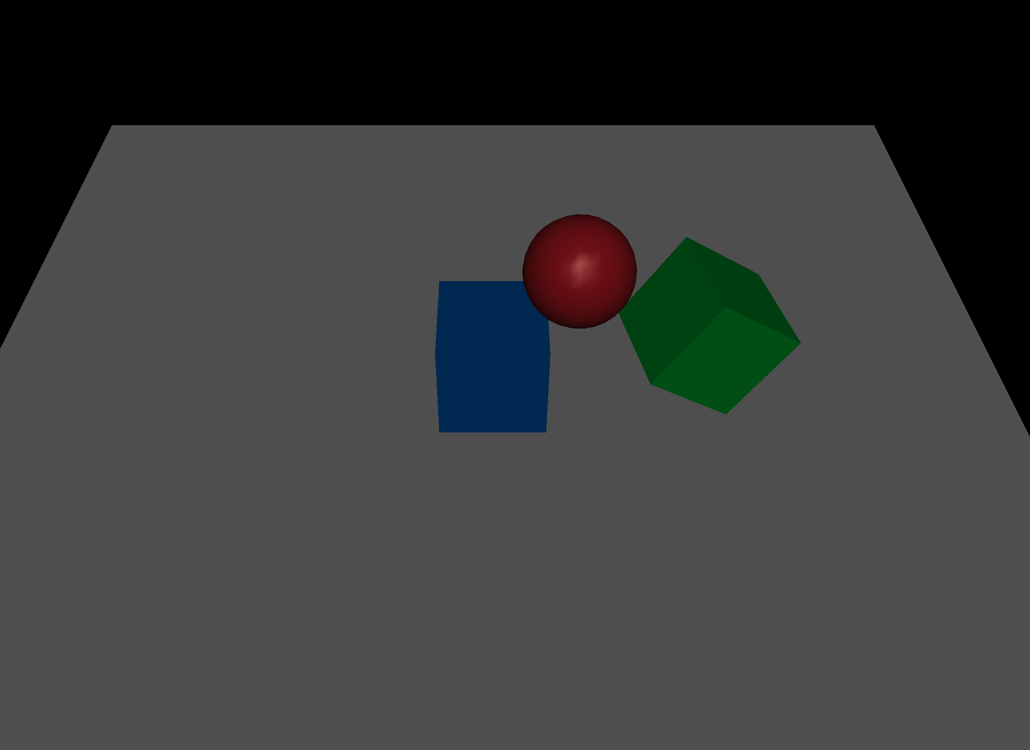